In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob as TexB
from collections import Counter
import warnings

In [3]:
CustomFeed = pd.read_csv("customer_feedback.csv", encoding='ISO-8859-1')
CustomFeed.head(5)

,date,mine,nps_score,first_name,last_name,customer_observations
0,02-01-2024,GOLD FIELDS GHANA,8,CYNTHIA,CARREON,WE'RE CURRENTLY TRIALING THE GROUND MOVEMENT D...
1,02-01-2024,MELIADINE MINE SITE (AGNICO-EAGLE),8,KIMBERLY,KEITUMETSE,"WE GOT THE LASER, GROUND MOVEMENT DETECTOR, RA..."
2,02-01-2024,VALE AGUA LIMPA,10,ROBERT,CRAIG,"WE'RE CURRENTLY TRIALING THE LASER, SEISMIC SE..."
3,03-01-2024,GOLD FIELDS GHANA,6,TIMOTHY,CARDENAS,"WE'VE INSTALLED SEISMIC SENSOR, RADAR, GROUND ..."
4,03-01-2024,PT PAMAPERSADA NUSANTARA (PAMA),8,WILLIAM,MALESA,"WE'VE INSTALLED LASER, RADAR DELIVERING DATA V..."


In [4]:
CustomFeed.isna().sum()

date                     0
mine                     0
nps_score                0
first_name               0
last_name                0
customer_observations    0
dtype: int64

In [5]:
Cf_summary = pd.DataFrame({
    'feature': CustomFeed.columns.values,
    'data_type': CustomFeed.dtypes.values,
    'null_values': CustomFeed.isna().mean().values * 100,
    'n_unique': CustomFeed.nunique().values,
    'sample_unique': [CustomFeed[col].unique() for col in CustomFeed.columns],
    
})
Cf_summary

,feature,data_type,null_values,n_unique,sample_unique
0,date,object,0.0,360,"[02-01-2024, 03-01-2024, 04-01-2024, 05-01-202..."
1,mine,object,0.0,424,"[GOLD FIELDS GHANA, MELIADINE MINE SITE (AGNIC..."
2,nps_score,int64,0.0,8,"[8, 10, 6, 9, 7, 5, 2, 4]"
3,first_name,object,0.0,309,"[CYNTHIA, KIMBERLY, ROBERT, TIMOTHY, WILLIAM, ..."
4,last_name,object,0.0,418,"[CARREON, KEITUMETSE, CRAIG, CARDENAS, MALESA,..."
5,customer_observations,object,0.0,793,[WE'RE CURRENTLY TRIALING THE GROUND MOVEMENT ...


In [6]:
def clean(text):

    text = text.lower()
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    text = re.sub(r"[^a-zA-Z0-9\sáéíóúñüÁÉÍÓÚÑÜ¿¡]", " ", text)
    
    text = re.sub(r"\s+", " ", text).strip()
    
    return text


CustomFeed['customer_observations'] = CustomFeed['customer_observations'].apply(clean)
CustomFeed['mine'] = CustomFeed['mine'].apply(clean)


In [7]:
def find_features(text):
    # Simple pattern matching for technical features
    patterns = [
        r'\b[\w]+ [\w]+ detector\b',  # 2-word + "detector"
        r'\b[\w]+ sensor\b',  
        r'\b[\w]+ analytics\b',
        r'\b[\w]+ alerts\b',
        r'\b[\w]+ monitoring\b',
        r'\b[\w]+ monitor\b',
        r'\b[\w]+ visualization\b'
    ]
    features = []
    text = str(text).lower()
    for pattern in patterns:
        features.extend(re.findall(pattern, text))
    return list(set(features))  # Remove duplicates

# Apply and count
all_features = CustomFeed['customer_observations'].apply(find_features).sum()

feature_counts = pd.Series(all_features).value_counts()
print(feature_counts.head(10))

time alerts                 360
predictive analytics        345
data visualization          334
ground movement detector    320
seismic sensor              301
7 monitoring                283
good monitoring               3
radar monitoring              2
stability monitoring          2
and monitoring                2
Name: count, dtype: int64


In [8]:
CustomFeed['nps_score'].value_counts()

nps_score
9     284
8     205
10    200
7      71
6      31
5       3
4       3
2       1
Name: count, dtype: int64

In [16]:
# Filter rows where nps_score is less than or equal to 7
detractor_rows = CustomFeed[CustomFeed['nps_score'] < 5]

# Show the distribution of sentiment values in those rows
print(detractor_rows['customer_observations'])

pd.set_option('display.width', 1000)


382                                                                                                                                                                                                          the pricing is too expensive and the customer support that we are receiving is very poor whenever we have an emergency most of the time company does not have enough skilled people to help us resolve the problem
390                                                                      the performance of the radar is very good we rely on it 100 but the reason i am giving a very low score is because one of the radars ssr omni which was delivered on april is still not being used as it is not working we have requested for a replacement and there is still no action we would like for gp to give us an update as soon as possible
403    the agreed upon regular support and maintenance is not consistently provided the technical staff is visits are very rare we have only had one detailed maintenanc

In [10]:
analyzer = SentimentIntensityAnalyzer()
custom_lexicon = {
    'top notch': 3.0,
    'dangerous job': 1.7,
    'chuffed': 2.3,
    'game changer': 2.5,
}
analyzer.lexicon.update(custom_lexicon)

def enhanced_sentiment(text):
    clean_text = str(text).lower().strip()
    
    # Get base VADER score
    score = analyzer.polarity_scores(clean_text)['compound']
    
    # Contextual pattern boosts
    positive_patterns = {
        r"top notch gear for a dangerous job": 0.8,
        r"quite chuffed": 0.7,
        r"made a noticeable difference": 0.4,
    }
    
    for pattern, boost in positive_patterns.items():
        if re.search(pattern, clean_text, re.IGNORECASE):
            score = max(score, boost)  
    
    # Strong positive word override
    positive_flags = ["excellent", "outstanding", "superb", "exceptional"]
    if any(word in clean_text for word in positive_flags):
        score = max(score, 0.9)  # Minimum 0.9 if strong positive present
    
    return min(max(score, -1), 1)  # Clamp to [-1, 1]


CustomFeed['sentiment'] = CustomFeed['customer_observations'].apply(enhanced_sentiment)
print(CustomFeed[['customer_observations', 'sentiment']].sample(5))

                                 customer_observations  sentiment
514  the team deployed seismic sensor ground moveme...     0.8000
106  we are using the laser seismic sensor equipped...     0.8000
4    we have installed laser radar delivering data ...     0.9110
131  we are currently trialing the ground movement ...     0.8643
648                     they provide excellent service     0.9000


In [11]:
features = [
    'real time alerts', 
    'predictive analytics',
    '24 7 monitoring',
    'data visualization',
    'ground movement detector',
    'seismic sensor'
]

feature_sentiments = {}
for feature in features:
    mentions = CustomFeed[CustomFeed['customer_observations'].str.contains(feature, case=False)]
    if len(mentions) > 0:
        feature_sentiments[feature] = mentions['sentiment'].mean()


results = pd.Series(feature_sentiments).sort_values(ascending=False)
print("\nTop Features by Average Sentiment:")
print(results.round(3))


Top Features by Average Sentiment:
seismic sensor              0.705
24 7 monitoring             0.705
real time alerts            0.703
data visualization          0.696
ground movement detector    0.691
predictive analytics        0.688
dtype: float64


In [12]:
results = []
for feature in features:
    # Get rows mentioning the feature
    mentions = CustomFeed[CustomFeed['customer_observations'].str.contains(feature, case=False)]
    total = len(mentions)
    
    if total > 0:
        # Count positive (>= 0.05) and negative (<= -0.05) sentiments
        positive = len(mentions[mentions['sentiment'] >= 0.05])
        negative = len(mentions[mentions['sentiment'] <= -0.05])
        neutral = total - positive - negative
        
        results.append({
            'feature': feature,
            'total_mentions': total,
            'positive_pct': (positive/total)*100,
            'negative_pct': (negative/total)*100,
            'neutral_pct': (neutral/total)*100
        })

# Create and format results DataFrame
result_df = pd.DataFrame(results).sort_values('positive_pct', ascending=False)
result_df[['positive_pct', 'negative_pct', 'neutral_pct']] = result_df[['positive_pct', 'negative_pct', 'neutral_pct']].round(1)

print("\nFeature Sentiment Distribution (%):")
print(result_df[['feature', 'positive_pct', 'negative_pct', 'neutral_pct', 'total_mentions']])


Feature Sentiment Distribution (%):
                    feature  positive_pct  negative_pct  neutral_pct  \
5            seismic sensor          99.0           0.0          1.0   
4  ground movement detector          98.4           0.0          1.6   
0          real time alerts          98.3           0.0          1.7   
2           24 7 monitoring          98.2           0.0          1.8   
3        data visualization          98.2           0.0          1.8   
1      predictive analytics          97.7           0.0          2.3   

   total_mentions  
5             301  
4             320  
0             360  
2             283  
3             334  
1             345  


In [13]:
# 1. Get the 20 most negative observations
negative_obs = CustomFeed.nsmallest(20, 'sentiment')['customer_observations']
pd.set_option('display.max_colwidth', None)
print(negative_obs)

560                                                                                                                                                                                                     we previously had a lot of issues with them and received bad customer service but that has improved a lot in fact they are now quite quick to respond whenever we encounter problems while it is not flawless we have no major issues with them now
775                                                                                                              the company equipment is good but the reason i gave an 8 is mainly because of the software issues that we are currently experiencing we are stuck on the software and have been trying to fix the issues however it seems that company has not been able to provide solutions to our problems as there has been no progress in this regard
730                                                                                                             

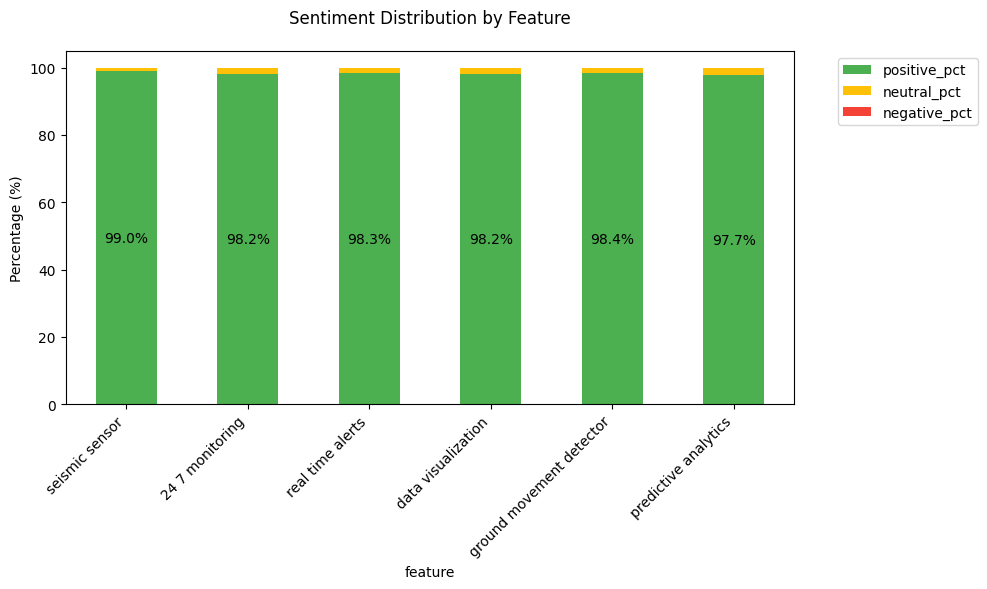

In [14]:
# Sample data (replace with your actual DataFrame)
data = {
    'feature': ['seismic sensor', '24 7 monitoring', 'real time alerts', 
               'data visualization', 'ground movement detector', 'predictive analytics'],
    'positive_pct': [99.0, 98.2, 98.3, 98.2, 98.4, 97.7],
    'neutral_pct': [1.0, 1.8, 1.7, 1.8, 1.6, 2.3],
    'negative_pct': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
}
df = pd.DataFrame(data)

# Plot
ax = df.set_index('feature')[['positive_pct', 'neutral_pct', 'negative_pct']].plot(
    kind='bar', 
    stacked=True,
    color=['#4CAF50', '#FFC107', '#F44336'],
    figsize=(10, 6)
)

plt.title('Sentiment Distribution by Feature', pad=20)
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add value labels
for bar in ax.patches:
    width, height = bar.get_width(), bar.get_height()
    if height > 3:  # Only label visible segments
        x, y = bar.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                f'{height:.1f}%', 
                ha='center', 
                va='center')

plt.show()

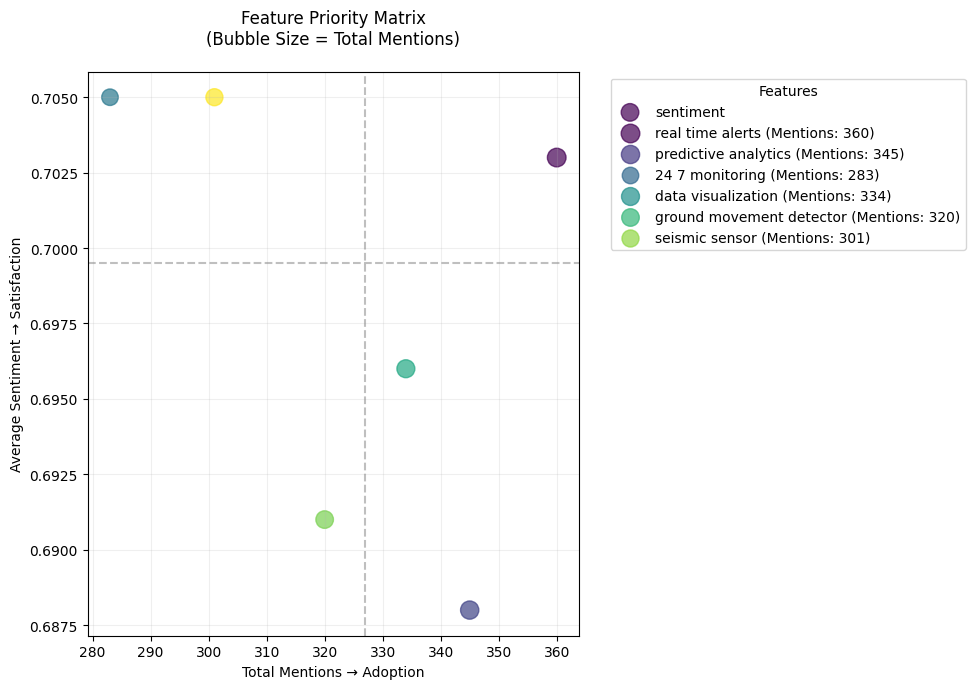

In [15]:
plot_df = pd.DataFrame({
    'feature': ['real time alerts', 'predictive analytics', '24 7 monitoring',
                'data visualization', 'ground movement detector', 'seismic sensor'],
    'mentions': [360, 345, 283, 334, 320, 301],
    'sentiment': [0.703, 0.688, 0.705, 0.696, 0.691, 0.705]
})

# Create plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    x='mentions',
    y='sentiment',
    s=plot_df['mentions']*0.5,  # Scale bubble size
    data=plot_df,
    alpha=0.7,
    c=np.arange(len(plot_df)),  # Unique colors
    cmap='viridis'
)

# Add legend
for i, row in plot_df.iterrows():
    plt.scatter([], [],  # Empty points for legend
                s=row['mentions']*0.5, 
                color=plt.cm.viridis(i/len(plot_df)),
                alpha=0.7,
                label=f"{row['feature']} (Mentions: {row['mentions']})")

plt.legend(
    title="Features",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True
)

# Formatting
plt.title('Feature Priority Matrix\n(Bubble Size = Total Mentions)', pad=20)
plt.xlabel('Total Mentions → Adoption')
plt.ylabel('Average Sentiment → Satisfaction')
plt.grid(alpha=0.2)

# Quadrant lines
plt.axvline(x=plot_df['mentions'].median(), ls='--', color='gray', alpha=0.5)
plt.axhline(y=plot_df['sentiment'].median(), ls='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()